### Objective

In this notebook , our primary objective is to create and train a multi output convolutional neural network to perform object localization.  We will also create custom callbacks and custom metrics in Keras.

### Project Structure

###### Task 1: Setting Work Envirement
###### Task 2: Download and Visualize Data 
###### Task 3: Create Examples 
###### Task 4: Plot Bounding Boxes 
###### Task 5: Data Generator 
###### Task 6: Model  
###### Task 7: Custom Metric: IoU 
###### Task 8: Compile The Model 
###### Task 9: Custom Callback 
###### Task 10: Model Training 

### Task 1: Setting Work Envirement

In [ ]:
#!pip install tensorflow==2.4

In [1]:

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

from PIL import Image, ImageDraw
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPool2D, BatchNormalization, Dropout


### Task 2: Download and Visualize Data

In [5]:
emojis_path='.\emojis'

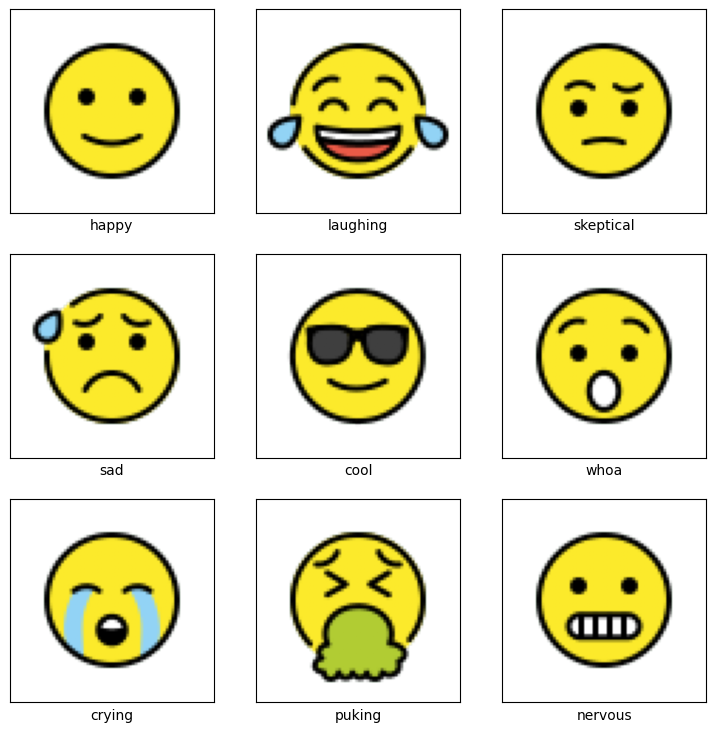

In [6]:
emojis = {
    0: {'name': 'happy', 'file': '1F642.png'},
    1: {'name': 'laughing', 'file': '1F602.png'},
    2: {'name': 'skeptical', 'file': '1F928.png'},
    3: {'name': 'sad', 'file': '1F630.png'},
    4: {'name': 'cool', 'file': '1F60E.png'},
    5: {'name': 'whoa', 'file': '1F62F.png'},
    6: {'name': 'crying', 'file': '1F62D.png'},
    7: {'name': 'puking', 'file': '1F92E.png'},
    8: {'name': 'nervous', 'file': '1F62C.png'}
}

plt.figure(figsize=(9, 9))

for i, (j, e) in enumerate(emojis.items()):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join(emojis_path, e['file'])))
    plt.xlabel(e['name'])
    plt.xticks([])
    plt.yticks([])
plt.show()

### Task 3: Create Examples

In [7]:
for class_id, values in emojis.items():
    png_file = Image.open(os.path.join('emojis', values['file'])).convert('RGBA')
    png_file.load()
    new_file = Image.new("RGB", png_file.size, (255, 255, 255))
    new_file.paste(png_file, mask=png_file.split()[3])
    emojis[class_id]['image'] = new_file

In [8]:
emojis

{0: {'name': 'happy',
  'file': '1F642.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72>},
 1: {'name': 'laughing',
  'file': '1F602.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72>},
 2: {'name': 'skeptical',
  'file': '1F928.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72>},
 3: {'name': 'sad',
  'file': '1F630.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72>},
 4: {'name': 'cool',
  'file': '1F60E.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72>},
 5: {'name': 'whoa',
  'file': '1F62F.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72>},
 6: {'name': 'crying',
  'file': '1F62D.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72>},
 7: {'name': 'puking',
  'file': '1F92E.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72>},
 8: {'name': 'nervous',
  'file': '1F62C.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72>}}

In [23]:
#create an image with the emojis placed on it
def create_image():
    class_id = np.random.randint(0,9) # we have 9 different classes
    image = np.ones((144,144,3)) * 255  # create a blank image 
    row=np.random.randint(0,72)
    col = np.random.randint(0,72)
    image[row:row+72 , col : col+72,:] = np.array(emojis[class_id]['image'])
    return image.astype('uint8'),class_id,(row + 10 ) / 144 ,(col + 10) / 144  #normalized image position 

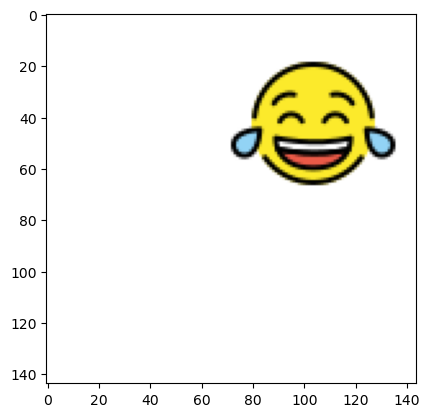

In [28]:
image,class_id,row,col=create_image()
plt.imshow(image)

### Task 4: Plot Bounding Boxes

In [53]:
def plot_bounding_box(image,gt_coords,pred_coords=[],norm=False):
    if norm :
        image *= 255.
        image=image.astype('uint8')
    image = Image.fromarray(image)
    draw=ImageDraw.Draw(image)
    row , col = gt_coords
    row *= 144
    col *= 144
    draw.rectangle((col, row , col+52,row+52),outline='green',width=3) #72 - 2 * 10 =52
    
    if len(pred_coords) == 2 :
        row , col = pred_coords
        row *= 144
        col *= 144
        draw.rectangle((col, row , col+52,row+52),outline='red',width=3) #72 - 2 * 10 =52
    return image
    

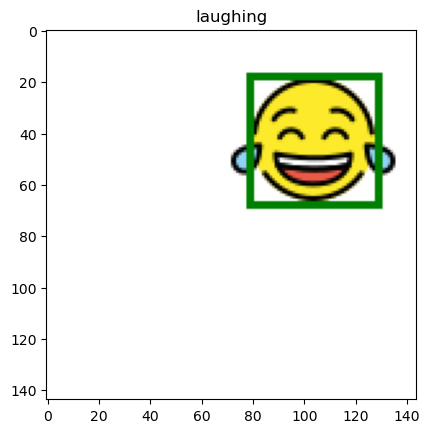

In [35]:
image=plot_bounding_box(image,gt_coords=[row,col])
plt.imshow(image)
plt.title(emojis[class_id]['name'])
plt.show()

### Task 5: Data Generator 

In [39]:
#Generating endless stream of training examples 
def data_generator(batch_size=16):
    while True :
        x_batch = np.zeros((batch_size,144,144,3))
        y_batch=np.zeros((batch_size,9))
        bbox_batch=np.zeros((batch_size,2))
        
        for i in range (0,batch_size):
            image,class_id,row,col = create_image()
            x_batch[i]=image / 255.
            y_batch[i,class_id] = 1.0
            bbox_batch[i] = np.array([row,col])
        yield {'image':x_batch},{'class_out':y_batch,'box_out':bbox_batch}

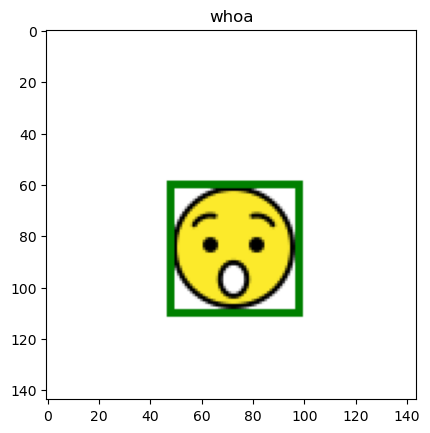

In [40]:
example,label= next(data_generator(1))
image=example['image'][0]
class_id=np.argmax(label['class_out'][0])
coords=label['box_out'][0]
image=plot_bounding_box(image,coords,norm=True)
plt.imshow(image)
plt.title(emojis[class_id]['name'])
plt.show()

### Task 6 : Model Architecture 

In [41]:
input_=Input(shape=(144,144,3),name='image')
x=input_
for i in range(0,5):
    n_filters = 2 **(4+i)
    x=Conv2D(n_filters,3,activation='relu')(x)
    x=BatchNormalization()(x)
    x=MaxPool2D(2)(x)
x=Flatten()(x)
x=Dense(256,activation='relu')(x)
class_out=Dense(9,activation='softmax',name='class_out')(x) #classification output
box_out=Dense(2,name='box_out')(x)     #regression output
model=tf.keras.models.Model(input_,[class_out,box_out])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 144, 144, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 142, 142, 16)         448       ['image[0][0]']               
                                                                                                  
 batch_normalization (Batch  (None, 142, 142, 16)         64        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 71, 71, 16)           0         ['batch_normalization[0][0

### Task 7: Custom Metric: IoU : Intersection over Union

In [97]:
class IoU(tf.keras.metrics.Metric):
    
    def __init__(self,**kwargs):
        
        super(IoU,self).__init__(**kwargs)
        self.iou= self.add_weight(name='iou',initializer='zeros')
        self.total_iou = self.add_weight(name='total_iou',initializer='zeros')
        self.num_ex=self.add_weight(name='num_ex',initializer='zeros')
        
    def update_state(self,y_true,y_pred,sample_weight=None):
        
        def get_box(y):
            
            rows,cols=y[:,0],y[:,1]
            rows,cols=rows * 144,cols * 144
            y1,y2=rows,rows+52
            x1,x2 = cols,cols+52
            return x1,y1,x2,y2
            
        def get_area(x1,y1,x2,y2):
            
            return tf.math.abs((x2 - x1)) * tf.math.abs((y2 - y1))
            
        gt_x1,gt_y1,gt_x2,gt_y2 = get_box(y_true)
        p_x1,p_y1,p_x2,p_y2=get_box(y_pred)
        
        i_x1=tf.maximum(gt_x1,p_x1)
        i_y1=tf.maximum(gt_y1,p_y1)
        i_x2=tf.minimum(gt_x2,p_x2)
        i_y2=tf.minimum(gt_y2,p_y2)

        i_area=get_area(i_x1,i_y1,i_x2,i_y2)
        u_area=get_area(gt_x1,gt_y1,gt_x2,gt_y2) + get_area(p_x1,p_y1,p_x2,p_y2) - i_area
        iou = tf.math.divide(i_area,u_area)
        self.num_ex.assign_add(1)
        self.total_iou.assign_add(tf.reduce_mean(iou))
        self.iou = tf.math.divide(self.total_iou,self.num_ex)
        
    def result(self):
        return self.iou
        
    def reset_state(self):
        
        self.iou=self.add_weight(name='iou',initializer='zeros')
        self.total_iou = self.add_weight(name='total_iou',initializer='zeros')
        self.num_ex=self.add_weight(name='num_ex',initializer='zeros')
        

### Task 8 :Compiling the Model 

In [98]:
model.compile(
    loss={
        'class_out':'categorical_crossentropy',
        'box_out':'mse'
    },
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics={
        'class_out':'accuracy',
        'box_out':IoU(name='iou')
    }
)


### Task 9:Custom Callback : Model Testing

In [99]:
def test_model(model,test_datagen):
    example,label=next(test_datagen)
    x=example['image']
    y=label['class_out']
    box=label['box_out']
    pred_y,pred_box=model.predict(x)
    pred_coords = pred_box[0]
    gt_coords=box[0]
    pred_class = np.argmax(pred_y[0])
    image=x[0]
    gt=emojis[np.argmax(y[0])]['name']
    pred_class_name=emojis[pred_class]['name']
    image =plot_bounding_box(image,gt_coords,pred_coords,norm=True)
    color='green' if gt==pred_class_name else 'red'
    plt.imshow(image)
    plt.xlabel(f'Pred:{pred_class_name}',color=color)
    plt.ylabel(f'GT:{gt}',color=color)
    plt.xticks([])
    plt.yticks([])

In [100]:
def test(model):
    test_datagen=data_generator(1)
    plt.figure(figsize=(16,4))
    for i in range(0,6):
        plt.subplot(1,6,i+1)
        test_model(model,test_datagen)
    plt.show()

1/1 [==============================] - 0s 50ms/step


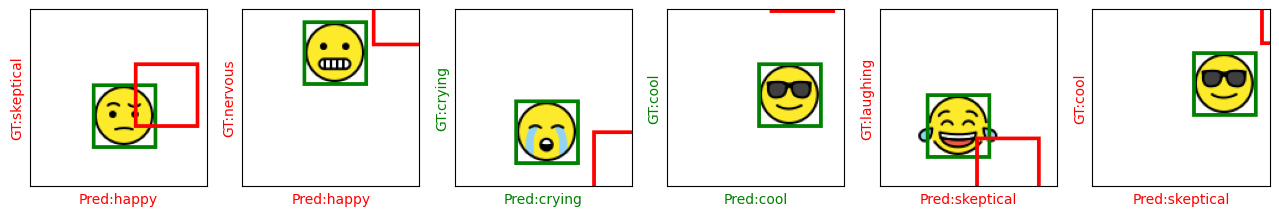

In [101]:
test(model)

In [102]:
class ShowTestImages(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs=None):
        test(self.model)

### Task 10 : Training The model

In [103]:
def lr_schedule(epoch,lr):
    if (epoch+1) % 5 == 0 :
        lr*=0.2
    return max(lr,3e-7)

Epoch 1/10
1/1 [==============================] - 0s 49ms/step


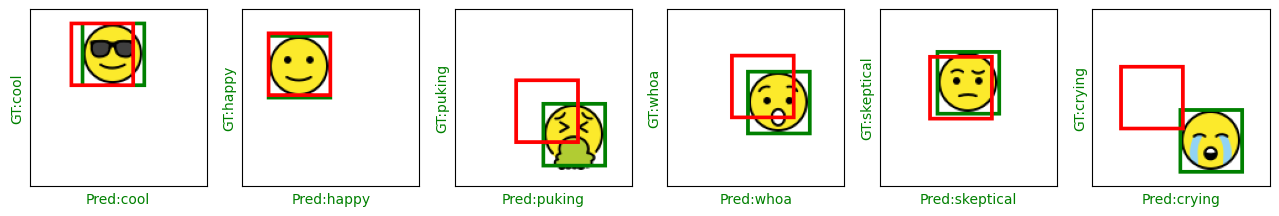

500/500 [==============================] - 123s 247ms/step - loss: 0.0017 - class_out_loss: 2.2525e-04 - box_out_loss: 0.0014 - class_out_accuracy: 1.0000 - box_out_iou: 0.0000e+00 - lr: 0.0010
Epoch 2/10
1/1 [==============================] - 0s 31ms/step


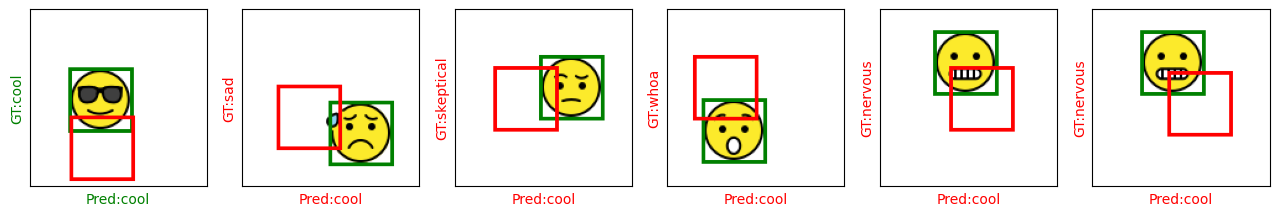

500/500 [==============================] - 122s 244ms/step - loss: 0.0626 - class_out_loss: 0.0491 - box_out_loss: 0.0135 - class_out_accuracy: 0.9887 - box_out_iou: 0.0000e+00 - lr: 0.0010
Epoch 3/10
1/1 [==============================] - 0s 48ms/step


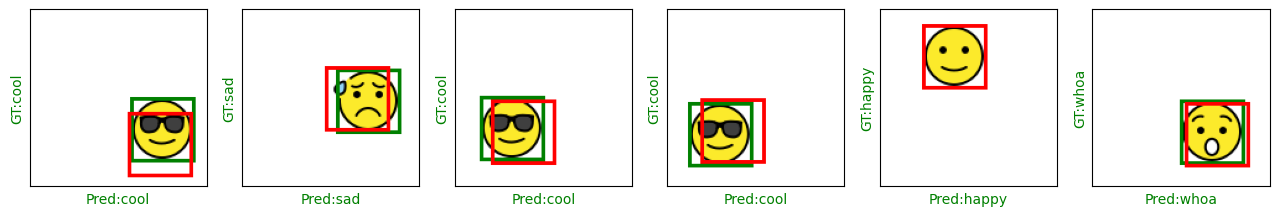

500/500 [==============================] - 119s 238ms/step - loss: 0.0053 - class_out_loss: 0.0022 - box_out_loss: 0.0030 - class_out_accuracy: 0.9994 - box_out_iou: 0.0000e+00 - lr: 0.0010
Epoch 4/10
1/1 [==============================] - 0s 53ms/step


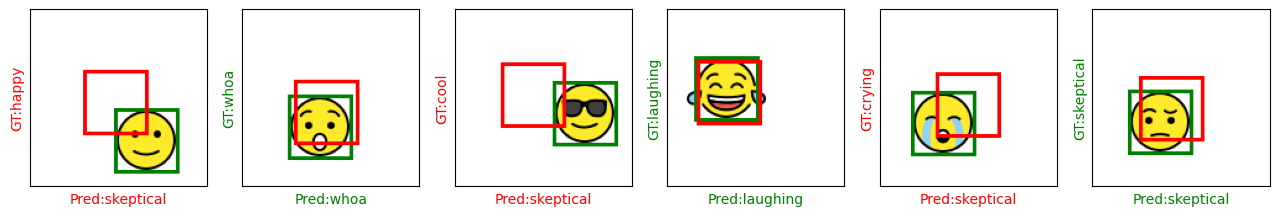

500/500 [==============================] - 119s 238ms/step - loss: 0.0040 - class_out_loss: 0.0022 - box_out_loss: 0.0017 - class_out_accuracy: 0.9994 - box_out_iou: 0.0000e+00 - lr: 0.0010


In [105]:
_ = model.fit(
    data_generator(),
    epochs=10,
    steps_per_epoch=500,
    callbacks=[
        ShowTestImages(),
        tf.keras.callbacks.EarlyStopping(monitor='box_out_iou',patience=3,mode='max'),
        tf.keras.callbacks.LearningRateScheduler(lr_schedule)
    ]
)

In [106]:
!mkdir -p saved_model

In [107]:
model.save('saved_model/my_model')



INFO:tensorflow:Assets written to: saved_model/my_model\assets


INFO:tensorflow:Assets written to: saved_model/my_model\assets
